# Aktuelle Limitierungen:

* Inhalte, die mehreren Fächern zugeordnet worden sind, zählen nur zu einem Fach
* Es werden nur Bearbeitungen gezählt
* Folgeevents einer Bearbeitung werden nicht zusammengefasst

In [1]:
from datetime import date
import pandas as pd
import mysql.connector
pd.options.mode.chained_assignment = None

from IPython.display import display, Markdown, HTML


display(Markdown(f"### Letztes Update: {date.today()}"))

### Letztes Update: 2023-05-25

In [2]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

#display(getSubjectFromUuid(127338))
#display(getSubjectFromUuid(63496))
#display(getSubjectFromUuid(1))
#display(getSubjectFromUuid(170741))
#display(getSubjectFromUuid(167497))

In [3]:
import json

json.dumps(querySingleton("""
select distinct(entity_link.parent_id ) from event_log join entity_link on entity_link.child_id = event_log.uuid_id where event_log.event_id = 4 and event_log.date > Date("2020-02-01");
"""));

In [4]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(100)

/tmp/ipykernel_47309/2145643300.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""


,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
...,...,...,...,...,...
252503,121732,2019-01-04 16:48:53,Jonathan,127576,Mathe
252505,121732,2019-01-04 16:49:01,Jonathan,127602,Mathe
252510,95854,2019-01-04 16:50:43,markus_janker,127600,Chemie


In [5]:
#Activation Rate pro Fach

def calc_activation_rates(days, edits, baseline):
    subject_list = list(filter(None, list(event_log['subject'].unique())))
    rates_df = pd.DataFrame(columns = ['subject', 'activation_rate', 'loss_rate'])

    for subject in subject_list:
        between_df = pd.DataFrame()
        activation_rate = int()
        loss_rate = int()
        for month in range(0,2):

            lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + month*30)
            upper_date = pd.Timestamp.today() - pd.Timedelta(days = month*30)
            df1 = pd.DataFrame()
            df2 = pd.DataFrame()
            df3 = pd.DataFrame()
            df4 = pd.DataFrame()
            df5 = pd.DataFrame()

            df1 = event_log[lower_date < event_log['date']] 
            df2 = df1[df1['date'] < upper_date]
            df3 = df2[df2['subject'] == subject]
            df4 = df3.groupby(by = ['actor_id', 'username', 'subject'], as_index = False).count()
            #Delete all authors under baseline
            df5 = df4[df4['uuid']>= baseline]
            df5['isActive'] = df5['uuid'].apply(lambda x: 1 if x >= edits else 0)

            if between_df.empty:
                between_df = df5
            else:
                between_df = pd.merge(between_df, df5[['actor_id', 'isActive']], on=["actor_id"])

        if not between_df.empty and 'isActive_x' in between_df.columns and 'isActive_y' in between_df.columns:
            between_df['change'] = between_df['isActive_x'] - between_df['isActive_y']
            activation_rate = between_df['change'][between_df['change']>0].sum() / len(between_df)
            loss_rate = between_df['change'][between_df['change']<0].sum() / len(between_df)
        else:
            continue
        append_srs = pd.Series([subject, round(activation_rate,2), round(loss_rate, 2)], index = rates_df.columns)
        rates_df = rates_df.append(append_srs, ignore_index=True)
    return rates_df
        

In [6]:
display(Markdown(f"### Aktivierungsrate pro Fach: Nicht aktive zu aktiven AutorInnen"))
display(Markdown(f"Edits: 10, im Zeitraum: Letzte 90 Tage"))
calc_activation_rates(days=90, edits=10, baseline = 0)

### Aktivierungsrate pro Fach: Nicht aktive zu aktiven AutorInnen

Edits: 10, im Zeitraum: Letzte 90 Tage

/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append m

,subject,activation_rate,loss_rate
0,Chemie,0.00,0.00
1,Mathe,0.00,0.00
2,Testbereich!,0.04,-0.07
3,Englisch,0.00,0.00
4,Nachhaltigkeit,0.00,-0.17
5,Community,0.00,-0.10
6,Physik,0.00,0.00
7,Prüfungsbereich Mathematik,0.00,0.00
8,Lerntipps,0.00,0.00
9,Informatik,0.20,0.00


In [7]:
display(Markdown(f"### Aktivierungsrate pro Fach: Aktive zu mittelaktiven Autorinnen"))
display(Markdown(f"Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage"))
calc_activation_rates(days=90, edits=50, baseline=10)

### Aktivierungsrate pro Fach: Aktive zu mittelaktiven Autorinnen

Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage

/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rates_df = rates_df.append(append_srs, ignore_index=True)
/tmp/ipykernel_47309/4253580534.py:41: FutureWarning: The frame.append m

,subject,activation_rate,loss_rate
0,Mathe,0.00,0.0
1,Testbereich!,0.00,-0.1
2,Englisch,0.00,0.0
3,Nachhaltigkeit,0.33,0.0
4,Community,0.00,0.0
5,Physik,0.00,0.0
6,Prüfungsbereich Mathematik,0.43,0.0
7,Lerntipps,0.00,0.0
8,Informatik,0.00,0.0
9,Math,0.00,0.0


In [8]:
#Activation Rate über alle Fächer hinweg

def calc_act_rates_wo_subj(days, edits, baseline):
    result_df = pd.DataFrame()

    for month in range(0,2):

        lower_date = pd.Timestamp.today() - pd.Timedelta(days = days + month*30)
        upper_date = pd.Timestamp.today() - pd.Timedelta(days = month*30)
        df1 = pd.DataFrame()
        df2 = pd.DataFrame()
        df3 = pd.DataFrame()

        df1 = event_log[lower_date < event_log['date']] 
        df2 = df1[df1['date'] < upper_date]
        df3 = df2.groupby(by = ['actor_id', 'username'], as_index = False).count()
        #Delete all authors under baseline
        df4 = df3[df3['uuid']>= baseline]
        df4['isActive'] = df4['uuid'].apply(lambda x: 1 if x >= edits else 0)

        if result_df.empty:
            result_df = df4
        else:
            result_df = pd.merge(result_df, df4[['actor_id', 'isActive']], on=["actor_id"])

    if not result_df.empty: #and 'isActive_x' in between_df.columns and 'isActive_y' in between_df.columns:
        result_df['change'] = result_df['isActive_x'] - result_df['isActive_y']
        activation_rate = result_df['change'][result_df['change']>0].sum() / len(result_df)
        loss_rate = result_df['change'][result_df['change']<0].sum() / len(result_df)
        
    return activation_rate, loss_rate

In [9]:
display(Markdown(f"### Aktivierungsrate Fächerübergreifend: Nicht aktive zu aktiven Autorinnen"))
display(Markdown(f"Edits: 10, im Zeitraum: Letzte 90 Tage"))
display(Markdown(f"Aktivierungsrate: {round(calc_act_rates_wo_subj(days=90, edits=10, baseline=0)[0], 2)}"))
display(Markdown(f"Verlustrate: {round(calc_act_rates_wo_subj(days=90, edits=10, baseline=0)[1], 2)}"))
display(Markdown(f"Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können"))

### Aktivierungsrate Fächerübergreifend: Nicht aktive zu aktiven Autorinnen

Edits: 10, im Zeitraum: Letzte 90 Tage

Aktivierungsrate: 0.03

Verlustrate: -0.05

Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können

In [10]:
display(Markdown(f"### Aktivierungsrate Fächerübergreifend: von aktiven zu mittelaktiven AutorInnen"))
display(Markdown(f"Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage"))
display(Markdown(f"Aktivierungsrate: {round(calc_act_rates_wo_subj(days=90, edits=50, baseline=10)[0], 2)}"))
display(Markdown(f"Verlustrate: {round(calc_act_rates_wo_subj(days=90, edits=50, baseline=10)[1], 2)}"))
display(Markdown(f"Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können"))

### Aktivierungsrate Fächerübergreifend: von aktiven zu mittelaktiven AutorInnen

Edits: von 10 auf 50, im Zeitraum: Letzte 90 Tage

Aktivierungsrate: 0.06

Verlustrate: -0.12

Bitte beachte, dass diese Zahl nicht analog zur Aktivierungs/Verlustrate pro Fach ist, da AutorInnen in verschiedenen Fächern aktiv sein können

In [11]:
import matplotlib.pyplot as plt

def show(subject=None, lower=10, time_interval=90):
    df = event_log.copy()
    
    if subject:
        df = df[df["subject"] == subject]
        if len(df) == 0:
            return
        
    edits_per_day = compute_edits_per_day_per_user(df)
    df = edits_per_day.rolling(time_interval, min_periods=time_interval).sum()
    df.dropna(inplace=True)
    
    display(Markdown(f"### Plot Anzahl Autor:innen mit Edits >= {lower}"))
    df.apply(lambda x: x.map(lambda y: y >= lower).sum(), axis=1).plot(figsize=(10,10))
    plt.show()
    
    df2 = pd.DataFrame({
        "edits": df.loc[df.index[-1]],
        "edits_before": df.loc[df.index[-1-time_interval]],
    })
    
    count = (df2["edits"] >= lower).sum()
    
    display(Markdown(f"Anzahl Autor:innen mit Edits >= {lower}: {count}"))
    
    display(Markdown(f"### Autor:innen mit aktuellen Edits >= {lower}"))
    d = df2[df2["edits"] >= lower][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Verlorene Autor:innen mit aktuellen Edits < {lower} und vorher Edits >= {lower}"))
    d = df2[(df2["edits"] < lower) & (df2["edits_before"] >= lower)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind)"))
    df3 = edits_per_day.cumsum()
    df3 = pd.DataFrame({
        "edits": df3.loc[df.index[-1]],
        "edits_before": df3.loc[df.index[-1-time_interval]],
    })
    d = df3[(df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind) + Edits < {lower}"))
    d = df3[(df3["edits"] < lower) & (df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)

def compute_edits_per_day_per_user(df, since=4*365.25):
    current_date = df["date"].max()     # This should probably be set to today!
    df = df[df["date"] > current_date - pd.Timedelta(days=since)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

#show()

### Plot Anzahl Autor:innen mit Edits >= 10

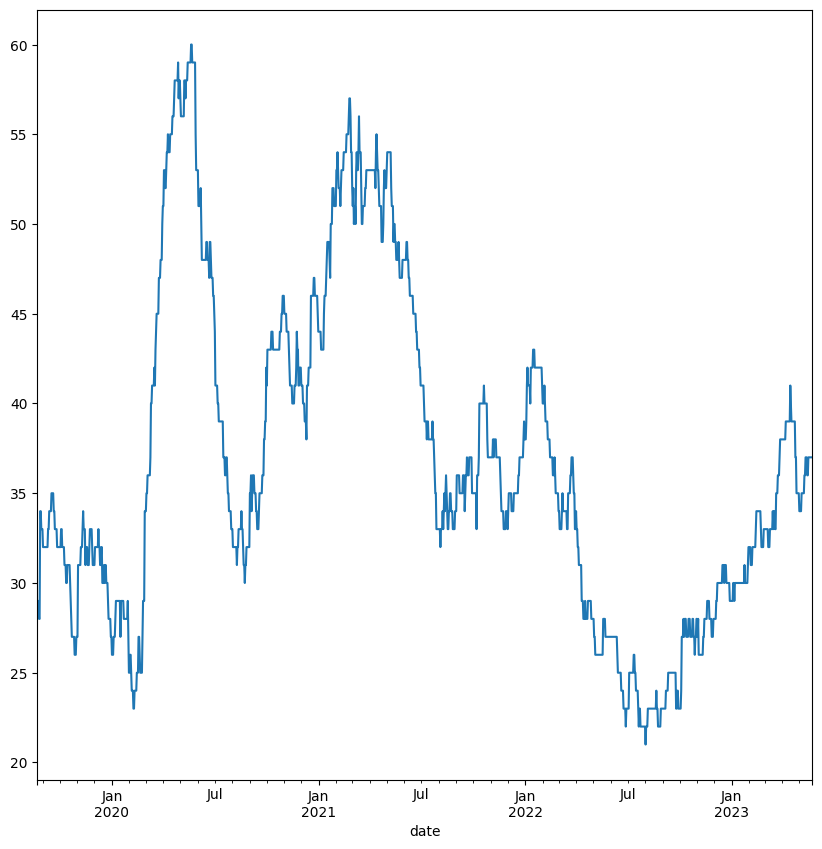

Anzahl Autor:innen mit Edits >= 10: 37

### Autor:innen mit aktuellen Edits >= 10

,edits
Sascha_Lill_95,516.0
Felix_Eccardt,478.0
Kowalsky,418.0
metzgaria,269.0
Karin,243.0
Corinna,129.0
Peter,124.0
BerndF,111.0
Nadine_Gabel,90.0
Julian1492,90.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Carina,9.0
dal,7.0
SophiaBockmeir,7.0
sahara91,5.0
anne22,3.0
Gesine,3.0
kathongi,1.0
Laura97,0.0
Powerjoko,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Julian1492,90.0
line,46.0
KlausB,38.0
Helenita,35.0
driedger,30.0
wdihgefhgflj,17.0
silvia-b,14.0
Jahnavi_Zalki,11.0
Maggie9900,8.0
Hoeller7,7.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Maggie9900,8.0
Hoeller7,7.0
Yummy,6.0
AnnaTichs,5.0
m-kahre,4.0
testifoo,4.0
Samsumehl,4.0
Adam09,3.0
Par145qv,3.0
a-pong,3.0


In [12]:
show()

### Plot Anzahl Autor:innen mit Edits >= 100

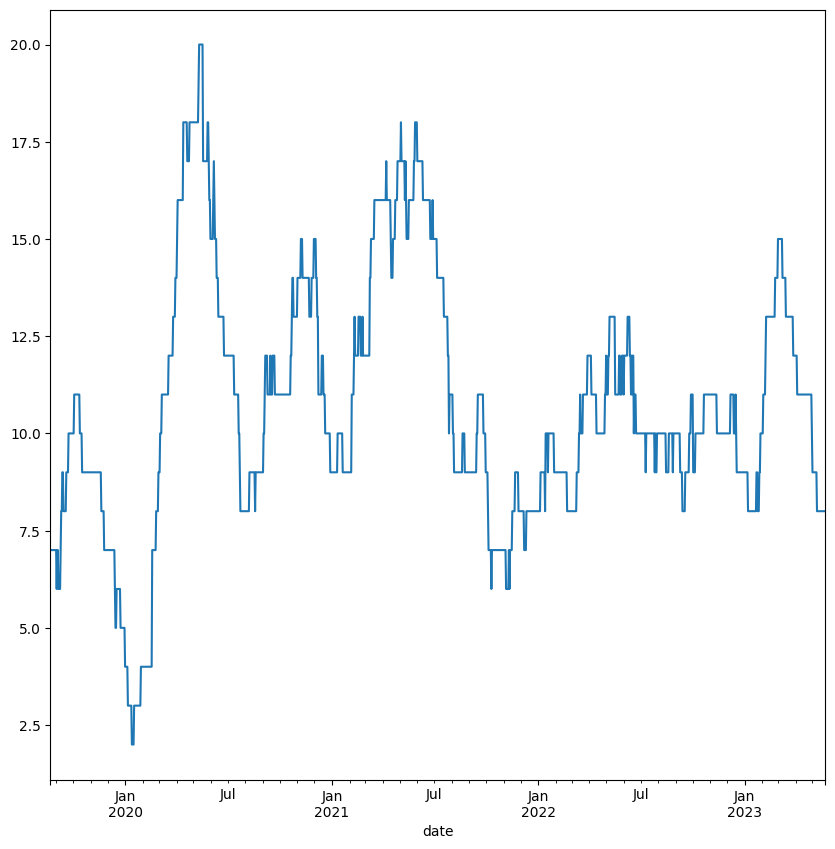

Anzahl Autor:innen mit Edits >= 100: 8

### Autor:innen mit aktuellen Edits >= 100

,edits
Sascha_Lill_95,516.0
Felix_Eccardt,478.0
Kowalsky,418.0
metzgaria,269.0
Karin,243.0
Corinna,129.0
Peter,124.0
BerndF,111.0


### Verlorene Autor:innen mit aktuellen Edits < 100 und vorher Edits >= 100

,edits
raha,52.0
LinaMaria,47.0
konstanze,25.0
Alexandra-Wolfram,21.0
Gerlinger,13.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Julian1492,90.0
line,46.0
KlausB,38.0
Helenita,35.0
driedger,30.0
wdihgefhgflj,17.0
silvia-b,14.0
Jahnavi_Zalki,11.0
Maggie9900,8.0
Hoeller7,7.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 100

,edits
Julian1492,90.0
line,46.0
KlausB,38.0
Helenita,35.0
driedger,30.0
wdihgefhgflj,17.0
silvia-b,14.0
Jahnavi_Zalki,11.0
Maggie9900,8.0
Hoeller7,7.0


In [13]:
show(lower=100)

### Plot Anzahl Autor:innen mit Edits >= 50

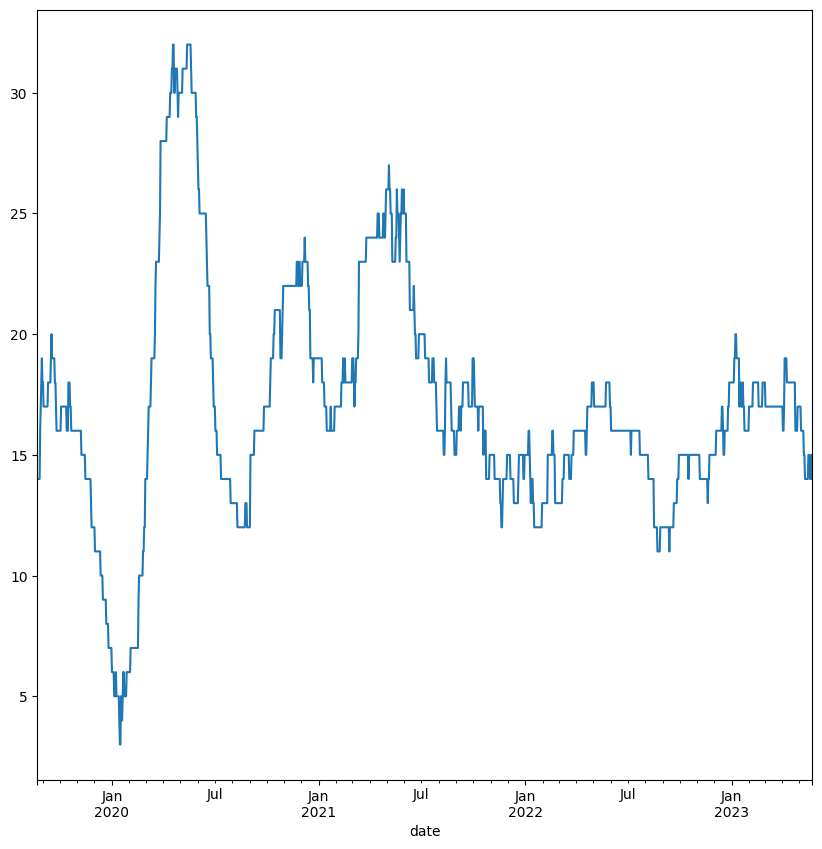

Anzahl Autor:innen mit Edits >= 50: 14

### Autor:innen mit aktuellen Edits >= 50

,edits
Sascha_Lill_95,516.0
Felix_Eccardt,478.0
Kowalsky,418.0
metzgaria,269.0
Karin,243.0
Corinna,129.0
Peter,124.0
BerndF,111.0
Nadine_Gabel,90.0
Julian1492,90.0


### Verlorene Autor:innen mit aktuellen Edits < 50 und vorher Edits >= 50

,edits
LinaMaria,47.0
Tina_B,42.0
Annika-Hemlein,31.0
hwlang,27.0
konstanze,25.0
Alexandra-Wolfram,21.0
Gerlinger,13.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Julian1492,90.0
line,46.0
KlausB,38.0
Helenita,35.0
driedger,30.0
wdihgefhgflj,17.0
silvia-b,14.0
Jahnavi_Zalki,11.0
Maggie9900,8.0
Hoeller7,7.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 50

,edits
line,46.0
KlausB,38.0
Helenita,35.0
driedger,30.0
wdihgefhgflj,17.0
silvia-b,14.0
Jahnavi_Zalki,11.0
Maggie9900,8.0
Hoeller7,7.0
Yummy,6.0


In [14]:
show(lower=50)

### Plot Anzahl Autor:innen mit Edits >= 1

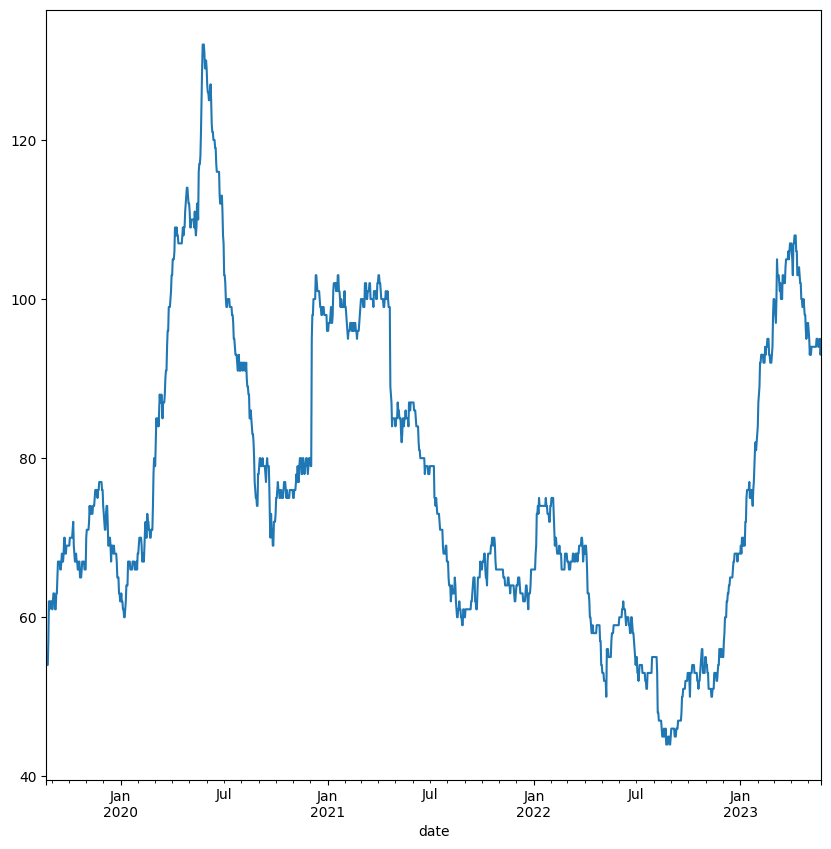

Anzahl Autor:innen mit Edits >= 1: 94

### Autor:innen mit aktuellen Edits >= 1

,edits
Sascha_Lill_95,516.0
Felix_Eccardt,478.0
Kowalsky,418.0
metzgaria,269.0
Karin,243.0
...,...
orP_55856,1.0
Joker,1.0
esma14,1.0
samusahne,1.0


### Verlorene Autor:innen mit aktuellen Edits < 1 und vorher Edits >= 1

,edits
Maria_F,0.0
willi1387,0.0
Ibra,0.0
Lehrer85,0.0
KevinH,0.0
Patole,0.0
Nati,0.0
mikawaf,0.0
Hannolo,0.0
herrbue,0.0


,edits
Maria_F,0.0
willi1387,0.0
Ibra,0.0
Lehrer85,0.0
KevinH,0.0
Patole,0.0
Nati,0.0
mikawaf,0.0
Hannolo,0.0
herrbue,0.0


In [15]:
show(lower=1)

In [16]:
event_log["subject"].unique()

In [17]:
for subject in ["Mathe", "Chemie", "Physik",
                  "Nachhaltigkeit", "Biologie", "Sandkasten", "Prüfungsbereich Mathematik",
               "Geographie", "Geschichte", "Community", "Informatik", "Englisch"]:
    
    display(Markdown(f"## Fach: {subject}"))
    show(subject=subject)

In [18]:
def show_no_authors():
    def current_no_authors(d):
        return d[pd.Timestamp.today() - d["date"] < pd.Timedelta("90 days")]["username"].nunique()
    
    def last_year_no_authors(d):
        return d[
            (d["date"] < pd.Timestamp.today() - pd.Timedelta("365 days")) &
            (d["date"] > pd.Timestamp.today() - pd.Timedelta("455 days"))
        ]["username"].nunique()
    
    return event_log.groupby("subject").apply(lambda d: pd.Series({
        "current no authors": current_no_authors(d),
        "last year no authors": last_year_no_authors(d)
    }))

show_no_authors()